In [1]:
import json
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import torch
import numpy as np
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg, instantiate
from detectron2.data import MetadataCatalog
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.utils.visualizer import Visualizer

In [2]:
f = open('bboxes.json')
data = json.load(f)

In [3]:
for file_name in data:
    img = cv2.imread(f'frames/{file_name}.jpeg')
    for player in data[file_name]:
        x, y, w, h = data[file_name][player]['box']
        x, y, w, h = int(x*img.shape[1]), int(y*img.shape[0]), int(w*img.shape[1]), int(h*img.shape[0])
        if x < 0 : x=0
        if y < 0 : y=0
#         cv2.imwrite(f'all_bboxes/bbox_{player}_{file_name}.png', img[y:y+h,x:x+w])
#         plt.imshow(img[y:y+h,x:x+w,::-1])
#         team = data[file_name][player]['team']
#         plt.title(team)
#         plt.show()
#         break
#     break

In [4]:
 class SegmentatorNewBaseline:
    def __init__(self, model_name, threshold=0.5):
        print ('Using model', model_name)
        
        # Get model config and weights (download if it doesn't exist):
        self.cfg = model_zoo.get_config(model_name, trained=True)
        # self.cfg = LazyConfig.load("/home/darkalert/builds/detectron2/configs/new_baselines/mask_rcnn_R_101_FPN_400ep_LSJ.py")
        self.cfg['model']['roi_heads']['box_predictor']['test_score_thresh'] = threshold
        
        # Init:
        self.model = instantiate(self.cfg.model)
        
        # Load a checkpoint:
        DetectionCheckpointer(self.model).load(self.cfg.train.init_checkpoint)
        
        self.model.eval()
        self.model.to('cuda')

    def __call__(self, img, viz=False):
        # Preprocess input image:
        img_tensor = torch.from_numpy(img)
        img_tensor = torch.permute(img_tensor, (2, 0, 1))
        batch = [{"image": img_tensor.to('cuda')}]
        
        # Inference:
        with torch.no_grad():
            outputs = self.model(batch)[0]

        # Vizualize:
        if viz:
            v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(self.cfg['dataloader']['train']['dataset']['names']), scale=3)
            img = v.draw_instance_predictions(outputs["instances"].to("cpu")).get_image()
            plt.imshow(img)
            plt.show()

        return outputs

In [5]:
def show(img, title='', bgr2rgb=True):
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    if bgr2rgb and img.ndim == 3:
        plt.imshow(img[...,::-1])
    else:
        plt.imshow(img)
    plt.show()

Using model new_baselines/mask_rcnn_R_101_FPN_400ep_LSJ.py


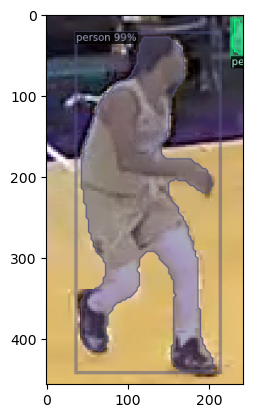

2


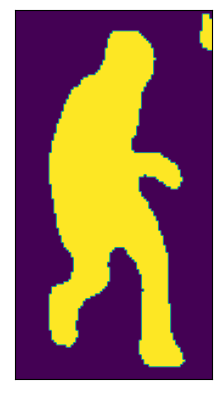

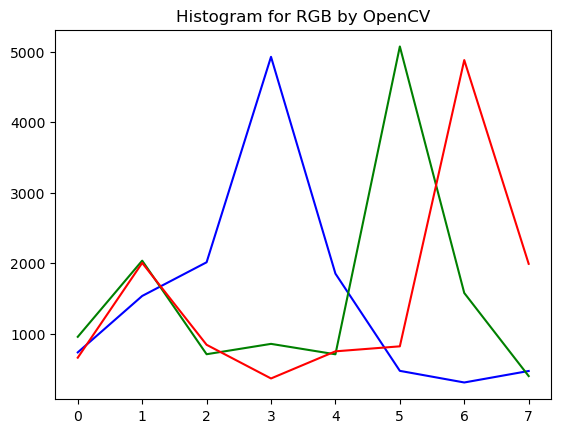

[ 734. 1535. 2013. 4929. 1852.  472.  307.  470.  955. 2036.  708.  855.
  707. 5076. 1577.  398.  659. 2004.  842.  364.  749.  820. 4883. 1991.]
(24,)


In [53]:
segmentator = SegmentatorNewBaseline('new_baselines/mask_rcnn_R_101_FPN_400ep_LSJ.py', 0.8)

# Open an image::
IMG_PATH = './all_bboxes/bbox_0_1310.png'
img = cv2.imread(IMG_PATH,1)

# Predict:
outputs = segmentator(img, viz=True)
print(len(outputs["instances"].pred_masks))


mask = np.zeros(img.shape[:2], dtype=np.uint8)

for m, l in zip(outputs["instances"].pred_masks,outputs["instances"].pred_classes):
    if l.item() == 0:
        mask += m.cpu().numpy()
        
show(mask, bgr2rgb=True)


color = ('b','g','r')
features = []
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[8],[0,256])
    plt.plot(histr,color = col)
    features.append(histr)
    
plt.title('Histogram for RGB by OpenCV')
plt.show()
print(np.array(features).ravel())
print(np.array(features).ravel().shape)